# Import the required Libraries

In [1]:
#%tensorflow_version 1.x
import tensorflow
#import talos
import keras
import time
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, GlobalAveragePooling3D, MaxPool3D
from keras.layers import Dropout, Input, Lambda, Concatenate
from keras.layers import Add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn import preprocessing 
from sklearn.svm import LinearSVC

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np

import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import scipy.io as sio
import os
from scipy.io import savemat
from skimage.util import random_noise
init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
print(tensorflow.__version__)

2.8.2


In [3]:
keras.__version__

'2.8.0'

# Data Loading

In [4]:
## GLOBAL VARIABLES
dataset = 'IP'
name = 'IP'

#dataset = 'PU'
#name = 'PU'

#dataset = 'SA'
#name = 'SA'

#dataset = 'KSC'
#name = 'KSC'

test_ratio = 0.70 # 0.80
windowSize = 13 #9 #11

In [5]:
def loadData(name):
   
    if name == 'IP':
        
        data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    elif name == 'SA':
        
        data = sio.loadmat('Salinas_corrected.mat')['salinas_corrected']
        labels = sio.loadmat('Salinas_gt.mat')['salinas_gt']
    elif name == 'PU':
        
        data = sio.loadmat('PaviaU.mat')['paviaU']
        labels = sio.loadmat('PaviaU_gt.mat')['paviaU_gt']
    elif name == 'KSC':
        data = sio.loadmat('KSC.mat')['KSC']
        labels = sio.loadmat('KSC_gt.mat')['KSC_gt']
    
    return data, labels

# Function for splitting the patches into Training and Testing samples

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

#Function for applying PCA

In [7]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

# Function for Zero Padding

In [8]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# Function to Extract Image cubes from the Dataset

In [9]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

# Oversampling of samples belonging to weaker classes

In [10]:
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

# Step 1 : Load the Dataset and the corresponding Groundtruth

In [11]:
X, labels = loadData(dataset)

X.shape, labels.shape

((145, 145, 200), (145, 145))

In [12]:
X.shape

(145, 145, 200)

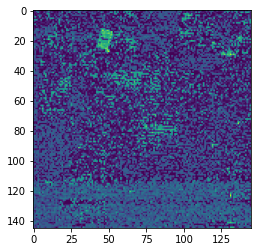

In [13]:
plt.imshow(X[:,:,0])

In [14]:
K = X.shape[2]

# Standardize the Dataset using MinMax Scaler

In [15]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
# transform data
s = X.shape
X_reshaped = np.reshape(X, (s[0]*s[1],s[2]))
scaled = scaler.fit_transform(X_reshaped)
X = np.reshape(scaled,(s[0],s[1],s[2]))

In [16]:
X.shape

(145, 145, 200)

# Apply the PCA on the Dataset.

In [17]:
K = 30 if dataset == 'IP' or 'KSC' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

# Extract the Image cubes from the Dataset

In [18]:
Xdata, ydata = createImageCubes(X, labels, windowSize=windowSize)

Xdata.shape, ydata.shape

((10249, 13, 13, 30), (10249,))

# Split the Image cubes into training and testing samples

In [19]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(Xdata, ydata, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 13, 13, 30), (7175, 13, 13, 30), (3074,), (7175,))

# Oversample the weak classes

In [20]:
#Xtrain, ytrain = oversampleWeakClasses(Xtrain, ytrain)

In [21]:
Xtrain.shape

(3074, 13, 13, 30)

# Model and Training

In [22]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
training_samples_after_oversampling = Xtrain.shape[0]
Xtrain.shape

(3074, 13, 13, 30, 1)

In [23]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 13, 13, 30, 1)

In [24]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [25]:
ytest = np_utils.to_categorical(ytest)
ytrain.shape

(3074, 16)

In [26]:
S = windowSize
L = K
output_units = 16
if (dataset == 'PU' or dataset == 'PC'):
  output_units = 9
elif(dataset =='KSC'):
  output_units = 13 
else:
  output_units = 16

In [27]:
layer_width = 256
Half_width = int(layer_width/2)

#Function for SFCN (Spinal Fully Connected Network)

In [28]:
def spnet(CNNDense,Half_width, layer_width,name):
  out = Lambda(lambda x:x[:, 0:Half_width])(CNNDense)#(flatten_layer)
  dense_layer1 = Dense(units = layer_width, activation='relu',input_shape=(Half_width,))(out) #(flatten_layer[:, 0:Half_width])
  dense_layer1 = Dropout(0.25)(dense_layer1) #0.25 

  out = Lambda(lambda x:x[:, Half_width:2*Half_width])(CNNDense)#(flatten_layer)
  out1 = (Concatenate(axis = 1))([out, dense_layer1])
  dense_layer2 = Dense(units = layer_width, activation='relu',input_shape=(Half_width + layer_width,))(out1)#(Concatenate(axis = 1))(out, dense_layer1)#([flatten_layer[:, Half_width:2*Half_width], dense_layer1])
  dense_layer2 = Dropout(0.3)(dense_layer2) #0.3 


  out = Lambda(lambda x:x[:,0:Half_width])(dense_layer2)
  out1 = (Concatenate(axis = 1))([out, dense_layer2])
  dense_layer3 = Dense(units=layer_width, activation='relu',input_shape=(Half_width,))(out1)#(Concatenate(axis = 1))([flatten_layer[:, 0:Half_width], dense_layer2])
  dense_layer3 = Dropout(0.4)(dense_layer3) #0.4 


  out = Lambda(lambda x:x[:, Half_width:2*Half_width])(dense_layer3)
  out1 = (Concatenate(axis = 1))([out, dense_layer3])
  dense_layer4 = Dense(units=layer_width, activation='relu',input_shape=(Half_width + layer_width,))(out1)#(Concatenate(axis = 1))([flatten_layer[:,Half_width:2*Half_width], dense_layer3])
  dense_layer4 = Dropout(0.5)(dense_layer4) #0.45 5

  x = Concatenate(axis = 1)([dense_layer1, dense_layer2])
  x = Concatenate(axis = 1)([x, dense_layer3])
  x = Concatenate(axis = 1, name = str(name))([x, dense_layer4])
  return x

# Proposed structure of HybridMSSN Deep Learning model

In [29]:
## input layer
input_layer = Input((S, S, L, 1))
initializer = keras.initializers.glorot_uniform()
conv_layer1 = Conv3D(filters=64, kernel_size= (3, 3, 3), activation='relu',padding = 'same', kernel_initializer=initializer)(input_layer)
conv_layer1 = MaxPool3D(pool_size=2)(conv_layer1)
conv_layer1 = Dropout(0.25)(conv_layer1)
conv_layer1 = BatchNormalization()(conv_layer1)
conv_layer2 = Conv3D(filters= 128, kernel_size=(3, 3, 3), activation='relu',padding = 'same', kernel_initializer=initializer)(conv_layer1)
conv_layer2 = MaxPool3D(pool_size=2)(conv_layer2)
conv_layer2 = Dropout(0.25)(conv_layer2)
conv_layer2 = BatchNormalization()(conv_layer2)
conv_layer3 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu',padding = 'same', kernel_initializer=initializer)(conv_layer2) #128
conv_layer3 = Dropout(0.25)(conv_layer3)
conv_layer3 = MaxPool3D(pool_size=2)(conv_layer3)
conv_layer3 = BatchNormalization()(conv_layer3)
conv3d_shape = conv_layer3.shape
conv_layer3r = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=256, kernel_size=(3,3), activation='relu',padding='same')(conv_layer3r)#256
conv_layer4d = Dropout(0.25)(conv_layer4)
FLATTEN1 = Flatten(name='FLATTEN1')(conv_layer1)
FLATTEN2 = Flatten(name='FLATTEN2')(conv_layer2)
FLATTEN3 = Flatten(name='FLATTEN3')(conv_layer3)
FLATTEN4 = Flatten(name='FLATTEN4')(conv_layer4d)
DENSE1 = spnet(FLATTEN1,256,128,'feature_dense1') 
DENSE2 = spnet(FLATTEN2,256,128, 'feature_dense2') 
DENSE3 = spnet(FLATTEN3,256,128, 'feature_dense3') 
DENSE4 = spnet(FLATTEN4,256,128, 'feature_dense4') 
CNNDense = Add()([DENSE1, DENSE2, DENSE3, DENSE4])
out = Lambda(lambda x:x[:, 0:Half_width])(CNNDense)#(flatten_layer)
dense_layer1 = Dense(units = layer_width, activation='relu',input_shape=(Half_width,))(out) #(flatten_layer[:, 0:Half_width])
dense_layer1 = Dropout(0.25)(dense_layer1) #0.25 
out = Lambda(lambda x:x[:, Half_width:2*Half_width])(CNNDense)#(flatten_layer)
out1 = (Concatenate(axis = 1))([out, dense_layer1])
dense_layer2 = Dense(units = layer_width, activation='relu',input_shape=(Half_width + layer_width,))(out1)#(Concatenate(axis = 1))(out, dense_layer1)#([flatten_layer[:, Half_width:2*Half_width], dense_layer1])
dense_layer2 = Dropout(0.3)(dense_layer2) #0.3 


out = Lambda(lambda x:x[:,0:Half_width])(dense_layer2)
out1 = (Concatenate(axis = 1))([out, dense_layer2])
dense_layer3 = Dense(units=layer_width, activation='relu',input_shape=(Half_width,))(out1)#(Concatenate(axis = 1))([flatten_layer[:, 0:Half_width], dense_layer2])
dense_layer3 = Dropout(0.4)(dense_layer3) #0.4 


out = Lambda(lambda x:x[:, Half_width:2*Half_width])(dense_layer3)
out1 = (Concatenate(axis = 1))([out, dense_layer3])
dense_layer4 = Dense(units=layer_width, activation='relu',input_shape=(Half_width + layer_width,))(out1)#(Concatenate(axis = 1))([flatten_layer[:,Half_width:2*Half_width], dense_layer3])
dense_layer4 = Dropout(0.5)(dense_layer4) #0.45 5

x = Concatenate(axis = 1)([dense_layer1, dense_layer2])
x = Concatenate(axis = 1)([x, dense_layer3])
x = Concatenate(axis = 1, name = 'features_dense')([x, dense_layer4])



output_layer = Dense(units=output_units, activation='softmax')(x) # (DENSE5)
"""
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
"""

"\n# define the model with input layer and output layer\nmodel = Model(inputs=input_layer, outputs=output_layer)\nadam = Adam(lr=0.001, decay=1e-06)\nmodel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])\n"

In [30]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

# Summary of the proposed HybridMSSN model

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 13, 30,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 13, 13, 30,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 6, 6, 15, 64  0           ['conv3d[0][0]']                 
                                )                                                             

In [32]:
#plot_model(model, to_file='HybridSpinalNet_model_plot.png', show_shapes=True, show_layer_names=True, dpi = 600)

# Model compilation

In [33]:
# compiling the model
adam = Adam(learning_rate = 0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [34]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the model and note the training time

In [35]:
start_time = time.time()
history = model.fit(Xtrain, ytrain, batch_size = 256, epochs= 100, callbacks=callbacks_list, verbose=1, validation_split=0.1)# ,validation_data=(Xtest, ytest)) #256
train_time = time.time() - start_time

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 2.5865 - accuracy: 0.2636
Epoch 1: accuracy improved from -inf to 0.26356, saving model to best-model.hdf5
11/11 [==============================] - 8s 234ms/step - loss: 2.5865 - accuracy: 0.2636 - val_loss: 2.6583 - val_accuracy: 0.1753
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.4019 - accuracy: 0.5354
Epoch 2: accuracy improved from 0.26356 to 0.53543, saving model to best-model.hdf5
11/11 [==============================] - 1s 136ms/step - loss: 1.4019 - accuracy: 0.5354 - val_loss: 2.3701 - val_accuracy: 0.1948
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.9183 - accuracy: 0.6811
Epoch 3: accuracy improved from 0.53543 to 0.68113, saving model to best-model.hdf5
11/11 [==============================] - 1s 129ms/step - loss: 0.9183 - accuracy: 0.6811 - val_loss: 1.8233 - val_accuracy: 0.6266
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.62

# Note the Testing time

In [36]:
start_time = time.time()
score = model.evaluate(Xtest, ytest, verbose=1)
test_time = time.time() - start_time

225/225 [==============================] - 2s 8ms/step - loss: 0.0075 - accuracy: 0.9976


# Classification Report

In [37]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.99      1.00      1000
           2       0.99      1.00      0.99       581
           3       1.00      1.00      1.00       166
           4       1.00      1.00      1.00       338
           5       1.00      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00       680
          10       1.00      1.00      1.00      1719
          11       1.00      0.99      0.99       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00        65

    accuracy                           1.00      7175
   macro avg       1.00   

# Function to compute Average Accuracy and Each Class Accuracy

In [38]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

# Computation of Classification Accuracies, Confusion Matrix and Loss

In [39]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'KSC':
        target_names = ['Scrub','Willow swamp','CP hammock','Slash pine','Oak/Broadleaf','Hardwood','Swamp','Graminoid marsh','Spartina marsh','Cattail marsh','Salt marsh','Mud flats','Water']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

# Write the Classification report into a text file.

In [40]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('training_samples_after_oversampling {}'.format(training_samples_after_oversampling))
    x_file.write('\n')
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('{}(seconds) train_time'.format(train_time))
    x_file.write('\n')
    x_file.write('{}(seconds) test_time'.format(test_time))
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 2s 8ms/step - loss: 0.0075 - accuracy: 0.9976


In [41]:
k = 1
for i in each_acc:
  print('c%s='%k,i)
  k = k+1

c1= 100.0
c2= 99.4
c3= 99.82788296041308
c4= 100.0
c5= 100.0
c6= 99.80430528375733
c7= 100.0
c8= 100.0
c9= 92.85714285714286
c10= 99.70588235294117
c11= 99.94182664339732
c12= 98.79518072289156
c13= 100.0
c14= 100.0
c15= 100.0
c16= 100.0


# Open the text file containing the  Classification Report and print them line by line.

In [42]:
with open('classification_report.txt') as f:
      line = f.readline()
      while line:
          line = f.readline()
          print(line)

training_samples_after_oversampling 3074

0.7450766861438751 Test loss (%)

99.76306557655334 Test accuracy (%)

99.72982693773503 Kappa accuracy (%)

99.76306620209058 Overall accuracy (%)

99.39576380128396 Average accuracy (%)

123.01901316642761(seconds) train_time

2.126746892929077(seconds) test_time

                              precision    recall  f1-score   support



                     Alfalfa       1.00      1.00      1.00        32

                 Corn-notill       1.00      0.99      1.00      1000

                Corn-mintill       0.99      1.00      0.99       581

                        Corn       1.00      1.00      1.00       166

               Grass-pasture       1.00      1.00      1.00       338

                 Grass-trees       1.00      1.00      1.00       511

         Grass-pasture-mowed       1.00      1.00      1.00        20

               Hay-windrowed       1.00      1.00      1.00       335

                        Oats       1.00      0.93 

In [43]:
f.close()

# Generate the predicted Image

In [44]:
height = labels.shape[0]
width = labels.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [45]:
X,pca = applyPCA(X, numComponents=numComponents)

In [57]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [47]:
X = padWithZeros(X, PATCH_SIZE//2)

In [58]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(labels[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction + 1

In [59]:
if name == 'IP':
    target_names = ['Background', 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                    ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']
    targetClass_colors = np.array([[250, 250, 250],
                              [255, 254, 137], [3,  28,  241], [255, 89,    1], [219, 255, 51],
                               [255,   2, 251], [89,  1,  255], [3,   171, 255], [12,  255,   7],
                               [172, 175,  84], [160, 78, 158], [101, 173, 255], [60,   91, 112],
                              [104, 192,  63], [139, 69,  46], [0, 102, 0], [77, 0, 77]])
    targetClass_colors = preprocessing.minmax_scale(targetClass_colors, feature_range=(0, 1))

elif name == 'SA':
    target_names = ['Background', 'Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                    'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                    'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                    'Vinyard_untrained','Vinyard_vertical_trellis']
    targetClass_colors = np.array([[250, 250, 250],
                              [255, 254, 137], [3,  28,  241], [255, 89,    1], [219, 255, 51],
                              [255,   2, 251], [89,  1,  255], [3,   171, 255], [12,  255,   7],
                              [172, 175,  84], [160, 78, 158], [101, 173, 255], [60,   91, 112],
                              [104, 192,  63], [139, 69,  46], [0, 102, 0], [77, 0, 77]])
    targetClass_colors = preprocessing.minmax_scale(targetClass_colors, feature_range=(0, 1))
    
elif name == 'PU':
    target_names = ['Background', 'Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                    'Self-Blocking Bricks','Shadows']
    targetClass_colors = np.array([[250, 250, 250],
                            [255, 254, 137], [3,  28,  241], [255, 89,    1], [5,   255, 133],
                            [255,   2, 251], [139, 69,  46], [101, 173, 255], [0, 102, 0],
                            [77, 0, 77]])
    targetClass_colors = preprocessing.minmax_scale(targetClass_colors, feature_range=(0, 1))

# Groundtruth Image

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(labels,cmap= mlp.colors.ListedColormap(targetClass_colors))
plt.axis("off")
cb = plt.colorbar()
loc = np.arange(0,max(np.unique(labels)),max(np.unique(labels))/float(len(targetClass_colors)))
cb.set_ticks(loc)
cb.set_ticklabels(targetClass_colors)
cb.set_ticklabels(target_names)
plt.savefig('IP_GroundTruth_Map.jpg', dpi= 600, bbox_inches='tight')

# Classification map of Predicted image

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(outputs.astype(int),cmap= mlp.colors.ListedColormap(targetClass_colors))
plt.axis("off")
#cb = plt.colorbar()
#loc = np.arange(0,max(np.unique(labels)),max(np.unique(labels))/float(len(targetClass_colors)))
#cb.set_ticks(loc)
#cb.set_ticklabels(colors)
#cb.set_ticklabels(IP_class_names)
plt.savefig('Predicted_Classification_Map.jpg', dpi= 600, bbox_inches='tight')